# Analysis of microarray - Vincent Dufour-Decieux

`%matplotlib inline` will allow to plot data directly inside the notebook.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


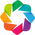

In [2]:
import holoviews as hv
import holoviews.util
from holoviews import streams
hv.extension('bokeh')

In [3]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

In [4]:
from IPython.display import HTML

In [5]:
cd ..

/Users/Espenel/Documents/bioimage-analysis/code_git/microarray_analysis_vincent


In [6]:
from io_czi import cziReader
from script.vincent import *

In [7]:
cd notebook

/Users/Espenel/Documents/bioimage-analysis/code_git/microarray_analysis_vincent/notebook


In [8]:
plt.rcParams['figure.figsize'] = 8,8
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['image.cmap'] = 'gray'

# Introduction

In Python, images are represented as `numpy` arrays. A single-channel, or grayscale, image is a 2D matrix of pixel intensities of shape `(row, column)`. We can construct a 3D volume as a series of 2D `planes`, giving 3D images the shape `(plane, row, column)`. Multichannel data adds a `channel` dimension in the final position containing color information. 

These conventions are summarized in the table below:


|Image type|Coordinates|
|:---|:---|
|2D grayscale|(row, column)|
|2D multichannel|(row, column, channel)|
|3D grayscale|(plane, row, column)|
|3D multichannel|(plane, row, column, channel)|

In [9]:
path = "images"

In [10]:
filename = "2017.10.20_H1975_L858R_4010065-105_improved.czi"

## Input/Output

Files in the .czi format can be loaded using the [czifile.py](https://www.lfd.uci.edu/~gohlke/code/czifile.py.html) from Christoph Gohlke.
> Note if your image are in .tif format they can be loaded with `skimage.io.imread` which will be faster

First we create a reader object:

In [11]:
reader = cziReader.CziReader(path + "/" + filename)

In [12]:
reader.czi.shape

(1, 1, 5, 9207, 11394, 1)

Second we applied the "load" method:

In [13]:
FAM, NA, HEX, CY5, DIC = reader.load()

# Metadata

Metadata are saved as a [XML.etree.ElemenTree](https://docs.python.org/2/library/xml.etree.elementtree.html) and can be access as follow:

Optionaly, we can use the "get_metadata" method to access the header of the czi file:

In [14]:
metadata = reader.get_metadata()

Use the next cell to print the metadata

In [ ]:
#for element in metadata.iter():
#    print("%s - %s" % (element.tag, element.text))

Here we will crop the image to remove the edge where there is some evaporation effect. The function `crop_show()` will show which region was cropped (red square), `crop()` will be much faster but will not show the croped region.
> The size of the crop should stay 7000, otherwise it will mess up the rest of the analysis. 

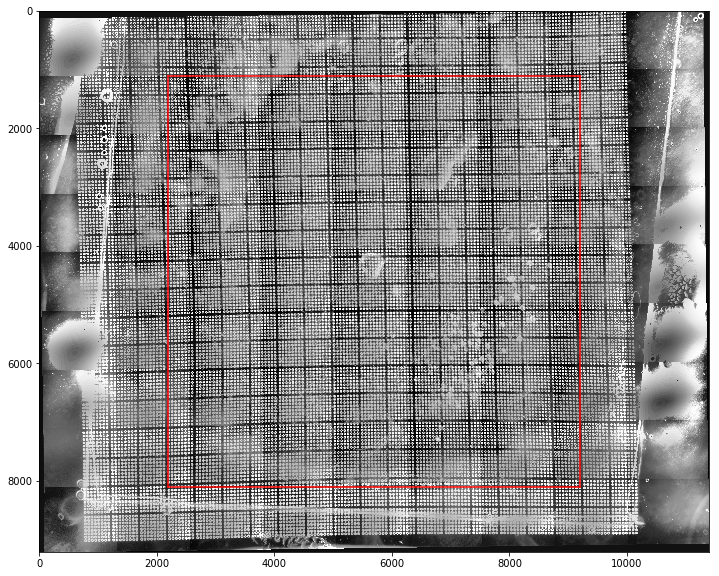

In [16]:
DIC_cropped = crop_show(DIC)

In [17]:
FAM_cropped = crop(FAM)
HEX_cropped = crop(HEX)

To accelerate the analysis we are cutting the image into 8 chunks:

In [18]:
chunks_img, x_block, y_block, overlap = chunks(DIC_cropped, overlap = 200, chunks = 8)

/Users/Espenel/anaconda/envs/vincent/lib/python3.6/site-packages/skimage/util/shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


We use the Canny filter to detect the edge of the wells

In [19]:
canny_lst = canny_chunks(chunks_img)

We use the Hough transform to find circle (well) in the image, more details [here](http://scikit-image.org/docs/dev/auto_examples/edges/plot_circular_elliptical_hough_transform.html).

In [20]:
hough_lst = hough_circle_chunk(canny_lst, low = 16, high = 22)

We can then draw circles using `skimage.draw.circle` everywhere we found a well:

In [21]:
circle_lst = draw_circle(canny_lst, hough_lst)

Finally we can stitch back the chuncks together and label the image (giving a different value for every circle):

In [22]:
labeled_img = stitched(canny_lst, circle_lst)

In [23]:
print("size of the image before cropping: {}, \n".format(DIC.shape) + 
       "after croping {}, \n".format(DIC_cropped.shape) + 
      "after finding the circle {}".format(labeled_img.shape))

size of the image before cropping: (9207, 11394), 
after croping (7000, 7000), 
after finding the circle (6530, 6500)


The function `show_RGB()` will use the module [holoviews](http://holoviews.org/) to show your image. The argument `s` allow you to down sample your image (to increase the speed). For example, s=8 will divide the resolution of your image by 8.

In [48]:
#show_RGB(labeled_img, s = 8)

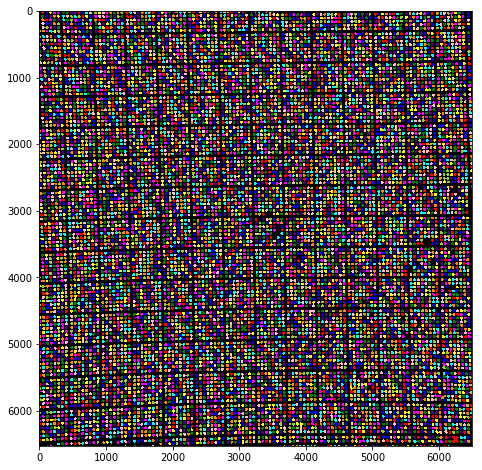

In [50]:
plt.imshow(label2rgb(labeled_img, bg_label=0))

The function `equaliz` ajust the contrast of the image as well as the size of it.

In [25]:
to_show_FAM, FAM_cropped_n = equaliz(FAM_cropped)

# Optional

The next few cells can be used to draw an ROI that you can exclude from the analysis in case some part of the microarray do not look good.

In [ ]:
data_1 = prop_lab(labeled_img)

In [ ]:
roi_to_rmv = []
def record_region(bounds):
    if 0 not in bounds:
        roi_to_rmv.append((bounds))   
    return label.select(x=(bounds[0], bounds[2]),y=(bounds[1], bounds[3]))

In [ ]:
image, label, box, bounds, dic = to_ROI(to_show_FAM, data_1)

In [ ]:
dmap = hv.DynamicMap(record_region, streams=[box])

In [ ]:
roi_to_rmv = []
(label * image * bounds * dmap).opts(dic)

In [ ]:
# JUST A GIF EXAMPLE OF WHAT IT LOOKS LIKE
HTML('<img src="images/roi.gif">')

In [ ]:
labeled_img = new_label_holo(roi_to_rmv, labeled_img, FAM_cropped_n)

Here we can see the region that have been removed from labeled image:

In [ ]:
show_RGB(labeled_img, s = 8)

# End optional:

Here we are going to measure the property (standard deviation, mean etc.) of the different well and create a [Pandas](https://pandas.pydata.org/) data frame with the data (a data frame is a two-dimensional data structure, i.e., data is aligned in a tabular fashion in rows and columns).
> Here you can measure the property of the different channel

In [26]:
to_show_HEX, HEX_cropped_n = equaliz(HEX_cropped)

The `prop_measure()` function can be user to measure the different property of the intensity image of interest, don't forget to `equaliz()` your image before you do the analysis. You can also choose to remove the background (back_sub = True or False) from your iamge. 

In [27]:
property_lst_FAM, props_FAM = prop_measure(labeled_img, FAM_cropped_n, back_sub = True)

In [28]:
property_lst_HEX, props_HEX = prop_measure(labeled_img, HEX_cropped_n, back_sub = True)

The data_panda() function will convert your "property" into a dataframe:

In [29]:
df_FAM = data_panda(property_lst_FAM)
df_HEX = data_panda(property_lst_HEX)

Finally you can chose to concatenate all the dataframes using the Pandas function `concat()`:

In [30]:
result = pd.concat([df_FAM, df_HEX], keys=['FAM', 'HEX'])

In [54]:
result.head()

25th percentile   50th percentile   75th percentile   mean intensity  \
FAM 0        360.424993        256.724055        216.752093      284.535251   
    1        295.498273        251.775757        217.614798      256.396066   
    2        288.422623        244.886574        217.484901      253.321958   
    3        275.461637        245.203032        218.950411      247.821104   
    4        282.816349        253.124477        227.860128      256.768541   

       median intensity  standard deviation  
FAM 0        256.724055           80.251728  
    1        251.775757           47.721729  
    2        244.886574           45.526766  
    3        245.203032           39.871412  
    4        253.124477           40.696985

In [55]:
result.tail()

25th percentile   50th percentile   75th percentile   \
HEX 12399        273.800882        263.179324        253.927605   
    12400        302.028454        294.489524        277.025919   
    12401        370.621647        357.564928        347.395540   
    12402        388.872569        377.197063        350.828149   
    12403        341.128288        272.090983        172.088352   

           mean intensity  median intensity  standard deviation  
HEX 12399      262.144873        263.179324           21.842085  
    12400      289.349384        294.489524           24.810167  
    12401      360.887852        357.564928           18.491359  
    12402      364.521192        377.197063           35.932697  
    12403      268.795610        272.090983          101.984115

We can then save the data frame to csv:

In [32]:
#df.to_csv("100217.csv")

The function `plot_result()` allow to visualyze the results:

In [ ]:
plot_result(property_lst_FAM, props_FAM, to_show_FAM)

In [41]:
HTML('<img src="images/plot_result3.gif">')

In [ ]:
plot_result(property_lst_HEX, props_HEX, to_show_HEX, dye = 'HEX')

In [42]:
HTML('<img src="images/plot_result4.gif">')